In [1]:
import time
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import qmc
import random
from datetime import datetime
from IPython.display import HTML, display

2024-04-15 11:30:02.445316: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 11:30:02.483900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 11:30:03.045593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


2024-04-15 11:30:04.344044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 11:30:04.363545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 11:30:04.363588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [4]:
tf.keras.backend.set_floatx("float64")

In [5]:
class Heat2DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), alpha=1):
        super(Heat2DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)
        self.alpha = alpha

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed=177013)

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model
    
    def save_model(self, file_path):
        self.model.save(file_path)
        print(f"Model saved to {file_path}.")

    def save_weights(self, file_path):
        self.model.save_weights(file_path)
        print(f"Weights saved to {file_path}.")

    def load_model(self, file_path):
        self.model = tf.keras.models.load_model(file_path)
        print(f"Model loaded from {file_path}.")

    def load_weights(self, file_path):
        self.model.load_weights(file_path)
        print(f"Weights loaded from {file_path}.")

    @tf.function
    def dirichlet_condition(self, x1_bc, x2_bc, t_bc, u_bc):
        x1_x2_t = tf.concat([x1_bc, x2_bc, t_bc], axis=1)
        u = self.model(x1_x2_t)
        return tf.reduce_mean(tf.square(u - u_bc))

    @tf.function
    def neuman_condition(self, x1_x2_bc_right):
        _, u_x1, _,  _, _ = self.forward(x1_x2_bc_right)
        return tf.reduce_mean(tf.square(u_x1)) # -∂u/∂x1 + ∂u/∂x1

    @tf.function
    def loss_fn(self, x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc):
        x1_x2_t = tf.concat([x1_in, x2_in, t_in], axis=1)
        u0 = self.model(x1_x2_t)
        u_x1 = tf.gradients(u0, x1_in)[0]
        u_x2 = tf.gradients(u0, x2_in)[0]
        u_t = tf.gradients(u0, t_in)[0]
        u_x1x1 = tf.gradients(u_x1, x1_in)[0]
        u_x2x2 = tf.gradients(u_x2, x2_in)[0]
        u_tt = tf.gradients(u_t, t_in)[0]
        heat_eq = u_t - self.alpha * (u_x1x1 - u_x2x2)#self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x1_bc, x2_bc, t_bc, u_bc)
        #bc_neuman = self.neuman_condition(x_d, y_d, t_d)

        return tf.reduce_mean(tf.square(heat_eq)) + 20 * bc_dirichlet
    
    def train(self, loss_threshold, x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc):
        loss_array = []
        start_time = time.time()

        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}')
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("1d_nonstationary_heat_equation_training.png")
        plt.show(block=False)

    def f(self, x1_x2):
        x1 = np.array([x[0] for x in x1_x2])
        x2 = np.array([x[1] for x in x1_x2])
        return -np.pi * np.sin(np.pi * x1) * np.sin(np.pi * x2)

2024-04-15 11:30:04.402930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 11:30:04.403051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 11:30:04.403072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 11:30:04.556744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 11:30:04.556837: I tensorflow/compile

In [6]:
N_of_train_points_2D = 141
N_of_test_points_2D = 100
N_of_fem_points_2D = 20
N_of_time_steps = 100
L_x1 = 0.0
R_x1 = 1.0
L_x2 = 0.0
R_x2 = 1.0
L_t = 0.0
R_t = 2.0
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 1e-1
Layers_2D = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Learning_rate_2D = 1e-3
alpha = 0.01
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)

In [7]:
model_2D = Heat2DPINN(3, 1, Layers_2D, 'tanh', Optimizer_2D, alpha)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 20)                80        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420  

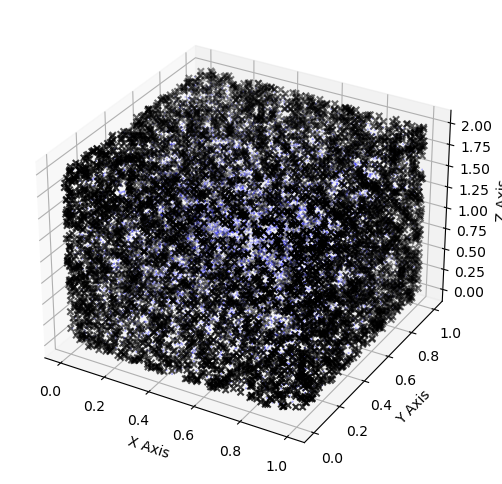

In [8]:
# Data generation
n_bc = 6
n_data_per_bc = 1000
Nc = 10000

engine = qmc.LatinHypercube(d=2)
data = np.zeros([n_bc, n_data_per_bc, 4])

for i in range(n_bc):
    if i < 2:
        points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1, L_t], [R_x1, R_t])
        if i == 0:
            data[i, :, 0] = L_x1
            data[i, :, 1:3] = points
        else:
            data[i, :, 0] = R_x1
            data[i, :, 1:3] = points
    elif i < 4:
        points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1, L_t], [R_x1, R_t])
        if i == 2:
            data[i, :, 0] = points[:, 0]
            data[i, :, 1] = L_x2
            data[i, :, 2] = points[:, 1]
        else:
            data[i, :, 0] = points[:, 0]
            data[i, :, 1] = R_x2
            data[i, :, 2] = points[:, 1]
    else:
        points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1, L_x2], [R_x1, R_x2])
        if i == 4:
            data[i, :, 0] = points[:, 0]
            data[i, :, 1] = points[:, 1]
            data[i, :, 2] = L_t
        else:
            data[i, :, 0] = points[:, 0] 
            data[i, :, 1] = points[:, 1]
            data[i, :, 2] = R_t

# BC Values
data[0, :, 3] = 0.0
data[1, :, 3] = 0.0
data[2, :, 3] = 0.0
data[3, :, 3] = 1.0
#values = np.sin(math.pi*data[2, :, 0]) - np.sin(2*math.pi*data[2, :, 1]) + np.sin(3*math.pi*data[2, :, 0])
data[4, :, 3] = 0

data = data.reshape(n_data_per_bc * n_bc, 4)

x1_bc, x2_bc, t_bc, u_bc = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3]])

engine = qmc.LatinHypercube(d=3)
colloc = qmc.scale(engine.random(n=Nc), [L_x1, L_x2, L_t], [R_x1, R_x2, R_t])

x1_in, x2_in, t_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1], colloc[:, 2]])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
#ax.title("Boundary Data points and Internal points")
ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker="x", c="k", label="BDP")
ax.scatter(colloc[:, 0], colloc[:, 1], colloc[:, 2], s=.2, marker=".", c="b", label="CP")
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc = map(
    lambda x: tf.convert_to_tensor(x, dtype=tf.float64),
    [x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc]
)

2024-04-15 11:30:05.996207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_29' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_29}}]]
2024-04-15 11:30:07.269436: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xc73abc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 11:30:07.269476: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-04-15 11:30:07.274277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 11:30:07.290869: I 

Epoch 0, Loss: 4.418368305068848
Epoch 100, Loss: 0.853195993271346
Epoch 200, Loss: 0.3829225481890864
Epoch 300, Loss: 0.34912116633293305
Epoch 400, Loss: 0.3372879625047012
Epoch 500, Loss: 0.32402968310913194
Epoch 600, Loss: 0.35960897632749883
Epoch 700, Loss: 0.32657282232753154
Epoch 800, Loss: 0.308684652670895
Epoch 900, Loss: 0.3028732336506287
Epoch 1000, Loss: 0.3018834678780926
Epoch 1100, Loss: 0.3098063955308102
Epoch 1200, Loss: 0.30117404580578877
Epoch 1300, Loss: 0.2965527956224511
Epoch 1400, Loss: 0.30476960577308443
Epoch 1500, Loss: 0.2987269812961983
Epoch 1600, Loss: 0.29250067215600895
Epoch 1700, Loss: 0.296757827512342
Epoch 1800, Loss: 0.2968505632252185
Epoch 1900, Loss: 0.29484932982632867
Epoch 2000, Loss: 0.28401410667196236
Epoch 2100, Loss: 0.28575243827837665
Epoch 2200, Loss: 0.2707471178903781
Epoch 2300, Loss: 0.26421024737452103
Epoch 2400, Loss: 0.25886399059089515
Epoch 2500, Loss: 0.2535831103847476
Epoch 2600, Loss: 0.2501540713103993
Epoch

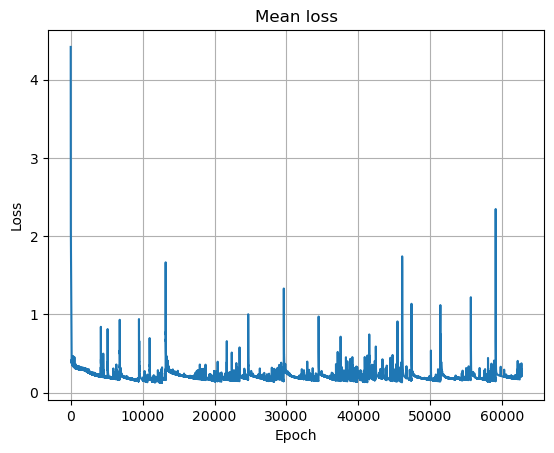

In [9]:
model_2D.train(loss_threshold_2D, x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc)

In [11]:
x1_test = np.linspace(L_x1, R_x1, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_x2, R_x2, N_of_test_points_2D)[:, np.newaxis]
t_test = np.linspace(L_t, R_t, N_of_time_steps)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)

x1_flat = np.repeat(x1_mesh.flatten()[:, np.newaxis], N_of_test_points_2D, axis=0)
x2_flat = np.repeat(x2_mesh.flatten()[:, np.newaxis], N_of_test_points_2D, axis=0)
t_flat = np.tile(t_test, (x1_mesh.size, 1))

test_input = np.hstack((x1_flat, x2_flat, t_flat))

u_pinn = model_2D.model(test_input).numpy()

u_pinn = u_pinn.reshape(N_of_test_points_2D, N_of_test_points_2D, N_of_test_points_2D)

In [ ]:
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')


# surf = ax.plot_surface(x1_mesh, x2_mesh, u_pinn[:, :, 0], cmap='viridis', linewidth=0, antialiased=False)


# ax.set_xlabel('x_2')
# ax.set_ylabel('x_1')
# ax.set_zlabel('u')
# ax.set_title('PINN Solution for 2D Nonstationary Heat Equation')


# ax.set_zlim(u_pinn.min(), u_pinn.max())


# def update(frame):
#     ax.clear()
#     ax.plot_surface(x1_mesh, x2_mesh, u_pinn[:, :, frame], cmap='viridis', linewidth=0, antialiased=False)
#     ax.set_xlabel('x_2')
#     ax.set_ylabel('x_1')
#     ax.set_zlabel('u')
#     ax.set_title('PINN Solution at t={:.2f}'.format(t_test[frame][0]))
#     ax.set_zlim(u_pinn.min(), u_pinn.max())


# ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)


# #ani.save('2d_nonstationary_heat_pinn_solution.mp4', writer='ffmpeg', fps=10)
# ani.save('2d_nonstationary_heat_pinn_solution.gif', writer=PillowWriter(fps=10))

# plt.close()


In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(u_pinn[:, :, 0], extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

fig.colorbar(cax, ax=ax)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
title = ax.set_title('PINN Solution at t=0')

def update(frame):
    cax.set_data(u_pinn[:, :, -frame])
    #print(frame)
    title.set_text('PINN Solution at t={:.2f}'.format(t_test[frame][0]))

ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)

ani.save('2d_nonstationary_heat_pinn_solution_heatmap.gif', writer=PillowWriter(fps=10))

plt.close()


random_int = random.randint(0, int(2e9))
current_time = datetime.now().strftime("%Y%m%d%H%M%S")
__counter__ = f"{current_time}{random_int}"

url = f"2d_nonstationary_heat_pinn_solution_heatmap.gif?{__counter__}"
html = f'<img src="{url}" alt="PINN Solution">'
display(HTML(html))


In [14]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

dt = (R_t - L_t) / N_of_time_steps
alpha = 0.01

mesh = RectangleMesh(Point(L_x1, L_x2), Point(R_x1, R_x2), N_of_fem_points_2D-1, N_of_fem_points_2D-1)
V = FunctionSpace(mesh, 'P', 1)

fine_mesh = RectangleMesh(Point(L_x1, L_x2), Point(R_x1, R_x2), N_of_test_points_2D-1, N_of_test_points_2D-1)
V_fine = FunctionSpace(fine_mesh, 'P', 1)

boundary_conditions = [
    DirichletBC(V, Constant(0), f"on_boundary && !near(x[1], {R_x2})"),  # u = 0 on boundaries except at x2 = R_x2
    DirichletBC(V, Constant(1), f"on_boundary && near(x[1], {R_x2})")     # u = 1 at x2 = R_x2
]

u_n = interpolate(Constant(0), V)  # u = 0 initially everywhere

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


u = Function(V)
u_fem = []

for n in range(N_of_time_steps):
    t = n*dt

    solve(a == L, u, boundary_conditions)
    u_n.assign(u)

    u_fine = interpolate(u, V_fine)
    
    u_fem.append(u_fine.compute_vertex_values(fine_mesh).reshape((N_of_test_points_2D, N_of_test_points_2D)))  # Fine mesh is 100x100, resulting in 101x101 points

bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [ ]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [15]:
def relative_l2_norm_error(u_pred, u_true):
    error_norm = np.linalg.norm(u_true - u_pred)
    true_norm = np.linalg.norm(u_true)
    return error_norm / true_norm


In [16]:
u_pinn = np.transpose(u_pinn, (2, 0, 1))
print("Mean Squared Error (PINN and FEM):", np.mean((u_fem - u_pinn)**2))
# u_pinn = np.transpose(u_pinn, (1, 2, 0))
# for i in range(0, 100):
#     indexTuple = np.unravel_index(np.argmax(np.abs(u_fem[i] - u_pinn[i])), u_fem[i].shape)
#     print(f"Mean Squared Error (PINN and FEM) {i}, {i * dt}:", np.mean((u_fem[i] - u_pinn[:,:,i])**2), np.max(np.abs(u_fem[i] - u_pinn[:,:,i])), np.unravel_index(np.argmax(np.abs(u_fem[i] - u_pinn[i])), u_fem[i].shape))
# print(np.array(u_fem).shape, np.array(u_pinn).shape)
relative_error = calculate_max_relative_error(np.array(u_fem), np.array(u_pinn))
print(f"Relative error (PINN and FEM) l_inf norm: {relative_error:.2f}%")
relative_norm_error = relative_l2_norm_error(np.array(u_fem), np.array(u_pinn))
print(f"Relative norm error (PINN and FEM) l_2 noem: {relative_norm_error:.2f}%")

Mean Squared Error (PINN and FEM): 0.009781418265032482
Relative error (PINN and FEM) l_inf norm: 92.84%
Relative norm error (PINN and FEM) l_2 noem: 0.50%


In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(u_fem[0].T, extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

fig.colorbar(cax, ax=ax)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
title = ax.set_title('FEM at t=0')

def update(frame):
    cax.set_array(u_fem[frame].T)
    title.set_text('FEM at t={:.2f}'.format(t_test[frame][0]))
ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)

#ani.save('2d_nonstationary_heat_pinn_solution_heatmap.mp4', writer=PillowWriter(fps=10))
ani.save('2d_nonstationary_heat_fem_heatmap.gif', writer=PillowWriter(fps=10))

plt.close()

random_int = random.randint(0, int(2e9))

current_time = datetime.now().strftime("%Y%m%d%H%M%S")

__counter__ = f"{current_time}{random_int}"

url = f"2d_nonstationary_heat_fem_heatmap.gif?{__counter__}"
html = f'<img src="{url}" alt="PINN Solution">'
display(HTML(html))

In [17]:
max_absolute_difference = np.max(np.abs(u_fem - u_pinn))
print(f"Maximum Absolute Difference (PINN and FEM): {max_absolute_difference}")


Maximum Absolute Difference (PINN and FEM): 0.9981266607601716


In [18]:
# Assuming the reshaped u_pinn, x1_mesh, x2_mesh, and t_test are defined as before

# Setup the figure
fig, ax = plt.subplots(figsize=(8, 6))

err = np.abs(np.array(u_fem) - u_pinn)

# Initial heatmap (the first frame)
cax = ax.imshow(err[:, :, 0], extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

# Add color bar once
fig.colorbar(cax, ax=ax)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
title = ax.set_title('Error at t=0')

def update(frame):
    cax.set_data(err[:, :, -frame])
    title.set_text('Error at t={:.2f}'.format(t_test[frame][0]))

ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)

#ani.save('2d_nonstationary_heat_pinn_solution_heatmap.mp4', writer=PillowWriter(fps=10))
ani.save('2d_nonstationary_heat_pinn_error_heatmap.gif', writer=PillowWriter(fps=10))

plt.close()

random_int = random.randint(0, int(2e9))

current_time = datetime.now().strftime("%Y%m%d%H%M%S")

__counter__ = f"{current_time}{random_int}"

url = f"2d_nonstationary_heat_pinn_error_heatmap.gif?{__counter__}"
html = f'<img src="{url}" alt="PINN Solution">'
display(HTML(html))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

err = np.abs(np.array(u_fem[0]) - np.array(u_pinn[:,:,0]))
print(np.unravel_index(np.argmax(err), u_fem[0].shape), np.max(err), u_fem[0][99, 66], u_pinn[99,66,0], u_fem[0][99, 66] - u_pinn[99,66,0])

cax = ax.imshow(err, extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

# Add color bar once
fig.colorbar(cax, ax=ax)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
title = ax.set_title('Error at t=0')


plt.show()


In [ ]:
# Assuming the reshaped u_pinn, x1_mesh, x2_mesh, and t_test are defined as before

# Setup the figure
fig, ax = plt.subplots(figsize=(8, 6))

err = u_pinn[:,:,0]

# Initial heatmap (the first frame)
cax = ax.imshow(err, extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

# Add color bar once
fig.colorbar(cax, ax=ax)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
title = ax.set_title('Error at t=0')


plt.show()
